In [3]:
import os
import sys
import path
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
sys.path.insert(0, path.Path(os.getcwd()).joinpath("..").abspath())

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# from IPython.display import set_matplotlib_formats

%matplotlib inline
# set_matplotlib_formats("svg")
sns.set_theme(style="whitegrid", font_scale=2, rc={"figure.figsize": (18, 9)})

## Common

In [5]:
import os

import numpy as np
import pandas as pd
import torch

from captum.attr import visualization as viz
from captum.attr import (
    Saliency, 
    IntegratedGradients,
    NoiseTunnel,
    LayerGradCam, 
    FeatureAblation, 
    LayerActivation, 
    LayerAttribution
)

from matplotlib.colors import LinearSegmentedColormap

## CV-based

In [ ]:
def unnormalize(tensor: torch.Tensor, mean, std, inplace=False):
    """Normalize a tensor image with mean and standard deviation.

    .. note::
        This transform acts out of place by default, i.e., it does not mutates the input tensor.

    Args:
        tensor: Tensor image of size (C, H, W) to be normalized.
        mean: Sequence of means for each channel.
        std: Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation inplace.

    Returns:
        torch.Tensor: Normalized Tensor image.

    Raises:
        TypeError: if `tensor` is not torch.Tensor
    """
    if not (torch.is_tensor(tensor) and tensor.ndimension() == 3):
        raise TypeError("tensor is not a torch image.")

    if not inplace:
        tensor = tensor.clone()

    dtype = tensor.dtype
    mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=dtype, device=tensor.device)
    tensor.mul_(std[:, None, None]).add_(mean[:, None, None])
    return tensor

In [ ]:
class EncoderWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        x, _ = self.module(x)
        return x

class HeadWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        x = self.module.classifier(x).mean(1)
        return x

class ModelWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        _, x = self.module(x)
        return x

In [ ]:
def attribute_image_features(algorithm, model, features, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(
        features,
        target=label, 
        **kwargs
    )
    
    return tensor_attributions

### Image

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
valid_dataset = datasets.CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

In [ ]:
features, label = valid_dataset[10]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [ ]:
plt.imshow(
    unnormalize(
        features[0].detach(), 
        (0.4914, 0.4822, 0.4465), 
        (0.2023, 0.1994, 0.2010)
    ).permute(1, 2, 0)
)

In [ ]:
from introspection.modules import resnet9

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = resnet9(in_channels=3, num_classes=10)
utils.unpack_checkpoint(checkpoint, model=model)
model = ModelWrapper(model)

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(features, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features, 
    label,
    baselines=features * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features, 
    label,
    baselines=features * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=100, 
    stdevs=0.2
)

In [ ]:
plt.imshow(
    unnormalize(
        features[0].detach(), 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    ).permute(1, 2, 0)
)

In [ ]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(grads.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

In [ ]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

In [ ]:
# plt.matshow(attr_ig_nt.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

#### Comparison

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

axs[0].imshow(
    unnormalize(
        features[0].detach(), 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    ).permute(1, 2, 0)
)

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    _ = viz.visualize_image_attr(
        np.transpose(show_attr.squeeze().cpu().detach().numpy(), (1,2,0)),
        np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
        method='heat_map',
        cmap=default_cmap,
        show_colorbar=True,
        sign='positive',
        outlier_perc=1,
        plt_fig_axis=(fig, axs[i+1]),
        use_pyplot=False,
    )

plt.show()

### Video

In [ ]:
from introspection.datasets import TemporalDataset
from introspection.settings import DATA_ROOT

valid_csv = pd.read_csv(
    f"{DATA_ROOT}/UCF11_updated_mpg_clean/valid.csv",
    header=None,
    names=["path", "class", "length"],
)

num_segments = 1
assert num_segments == 1
segment_len = 5
valid_dataset = TemporalDataset(
    valid_csv,
    f"{DATA_ROOT}/UCF11_updated_mpg",
    num_segments=num_segments,
    segment_len=segment_len,
)

In [ ]:
features, label = valid_dataset[0]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [ ]:
features.shape

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

In [ ]:
from introspection.modules import TemporalResNet

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = TemporalResNet(emb_features=256, out_features=11)
utils.unpack_checkpoint(checkpoint, model=model)
model = ModelWrapper(model)

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(features, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features, 
    label,
    baselines=features * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features, 
    label,
    baselines=features * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

In [ ]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
#         axs[i, j].imshow(grads[0, i*num_segments+j].detach().permute(1, 2, 0))
        _ = viz.visualize_image_attr(
            np.transpose(grads[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

In [ ]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
#         axs[i, j].imshow(attr_ig[0, i*num_segments+j].detach().permute(1, 2, 0))
        _ = viz.visualize_image_attr(
            np.transpose(attr_ig[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(attr_ig_nt[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

#### Comparison

In [ ]:
fig, axs = plt.subplots(4, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for j in range(segment_len):
    axs[0, j].imshow(features[0, j].detach().permute(1, 2, 0))

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(show_attr[0, j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[i+1, j]),
            use_pyplot=False,
        )

plt.show()

### Video-features

In [ ]:
from introspection.datasets import TemporalDataset
from introspection.settings import DATA_ROOT

valid_csv = pd.read_csv(
    f"{DATA_ROOT}/UCF11_updated_mpg_clean/valid.csv",
    header=None,
    names=["path", "class", "length"],
)

valid_dataset = TemporalDataset(
    valid_csv,
    f"{DATA_ROOT}/UCF11_updated_mpg",
    num_segments=None,
    segment_len=None,
)

In [ ]:
features, label = valid_dataset[0]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [ ]:
features.shape

In [ ]:
from introspection.modules import TemporalResNet

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = TemporalResNet(emb_features=256, out_features=11)
utils.unpack_checkpoint(checkpoint, model=model)

encoder = EncoderWrapper(model)
head = HeadWrapper(model)
model = ModelWrapper(model)

In [ ]:
features2 = encoder(features)

In [ ]:
features2.shape

In [ ]:
saliency = Saliency(head)
grads = saliency.attribute(features2, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(head)
attr_ig, delta = attribute_image_features(
    ig, 
    head,
    features2, 
    label,
    baselines=features2 * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(head)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    head,
    features2, 
    label,
    baselines=features2 * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

In [ ]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

In [ ]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

#### TopK video-features

In [ ]:
# [num_features; time_len; 1]
# -> [num_features; time_len;]
# -> [num_features;]
# -> softmax
# aka feature attention
attn_feat = attr_ig.permute((2, 1, 0)).squeeze(-1).sum(-1).softmax(-1)

In [ ]:
# [num_features; time_len; 1]
# -> [num_features; time_len;]
# -> [time_len;]
# -> softmax
# aka time attention
attn_time = attr_ig.permute((2, 1, 0)).squeeze(-1).sum(0).softmax(-1)

In [ ]:
num_segments = 1
segment_len = 5
topk_attn_time = attn_time.topk(segment_len).indices

In [ ]:
features3 = features[:, topk_attn_time, :, :, :]

In [ ]:
features3.shape

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features3[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(features3, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features3, 
    label,
    baselines=features3 * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features3, 
    label,
    baselines=features3 * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

In [ ]:
fig, axs = plt.subplots(4, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for j in range(segment_len):
    axs[0, j].imshow(features3[0, j].detach().permute(1, 2, 0))

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(show_attr[0, j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features3[0, j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[i+1, j]),
            use_pyplot=False,
        )

plt.show()

----

## TS-based

In [6]:
from src.settings import DATA_ROOT, LOGS_ROOT
from src.ts import load_ABIDE1

In [7]:
features, labels = load_ABIDE1()
features = np.swapaxes(features, 1, 2)  # [n_samples; seq_len; n_features]

In [8]:
# one-sample
# feature = features[5].astype(np.float32)
# feature = torch.tensor(feature).unsqueeze(0)
# feature.requires_grad = True
# all
feature = features.astype(np.float32)
feature = torch.tensor(feature)
feature.requires_grad = True

print(feature.shape)


torch.Size([569, 140, 53])


In [ ]:
from src.scripts.tune_ts_mlp import MLP
# AUC: 0.7030812324929973
model = MLP(
    input_size=53, 
    output_size=2,
    hidden_size=75, 
    num_layers=1, 
    dropout=0.30508830411407517,
)
logdir = LOGS_ROOT.joinpath("0002/model.best.pth")
checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
# print(checkpoint)
model.load_state_dict(checkpoint)
model = model.eval()
# ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# output = torch.sigmoid(model(feature))

In [ ]:
# from src.scripts.tune_ts_lstm import LSTM
# # AUC: 0.60286336756925
# model = LSTM(
#     input_size=53, 
#     hidden_size=97,
#     bidirectional=True,
#     num_layers=2,
#     fc_dropout=0.10739340844527928,
# )
# logdir = LOGS_ROOT.joinpath("220421.175503-ts-lstm-qFalse/0009/model.best.pth")
# checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
# model.load_state_dict(checkpoint)
# # # ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# # output = torch.sigmoid(model(feature))

In [ ]:
# from src.scripts.tune_ts_transformer import Transformer
# # AUC: 
# model = Transformer(
#     input_size=53, 
#     hidden_size=6 * 2, 
#     num_heads=2, 
#     num_layers=3, 
#     fc_dropout=0.3367242991440482,
# )
# logdir = LOGS_ROOT.joinpath("220417.103843-ts-transformer-qFalse/0005/model.best.pth")
# checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
# model.load_state_dict(checkpoint)
# # ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# # output = torch.sigmoid(model(feature))

In [17]:
saliency = Saliency(model)
print(saliency)

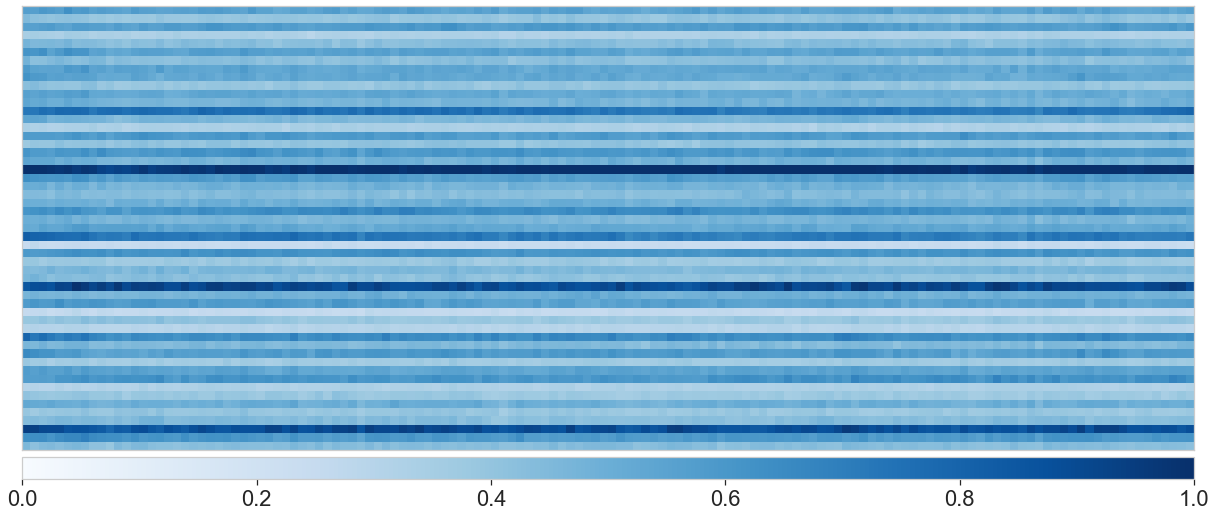

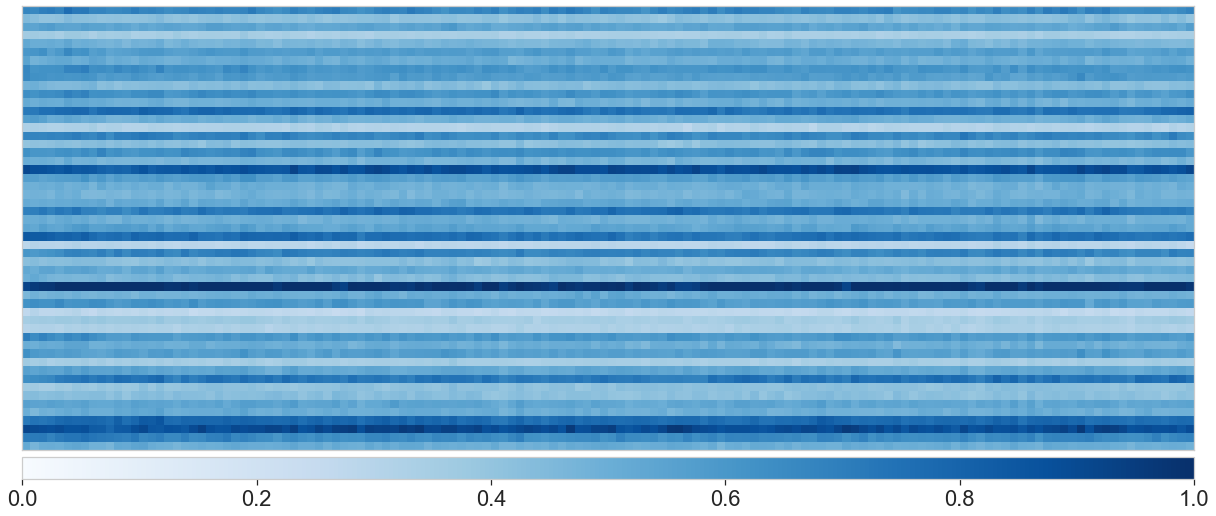

In [10]:
saliency = Saliency(model)


model.zero_grad()
grads0 = saliency.attribute(feature, target=0)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='negative',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
grads1 = saliency.attribute(feature, target=1)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

Approximation delta:  tensor([1.8682e-01, 5.8389e-02, 3.9922e-01, 3.2490e-01, 1.0431e+00, 2.4755e-01,
        1.0133e-01, 1.3554e-01, 1.2831e-02, 2.4220e-01, 9.3750e-02, 5.8826e-01,
        1.2293e-01, 4.5787e-01, 3.3134e-01, 2.3495e-01, 2.9228e-01, 4.7438e-02,
        1.8281e-01, 1.7585e-01, 4.2856e-02, 5.3347e-02, 2.1468e-01, 1.8127e-01,
        1.3148e-01, 3.6978e-02, 6.2519e-02, 2.3353e-01, 3.6763e-01, 4.3891e-01,
        1.8704e-01, 1.1825e-01, 1.9595e-01, 5.8880e-02, 9.9800e-02, 8.3272e-01,
        1.1489e-01, 1.0411e-01, 5.1210e-01, 2.0291e-01, 2.0544e-01, 1.9659e-01,
        1.8201e-02, 4.1439e-01, 7.5455e-02, 2.8172e-01, 1.8158e-01, 1.7915e-01,
        1.9340e-01, 2.0908e-01, 2.2184e-01, 3.3993e-01, 8.0880e-02, 3.0729e-01,
        1.8166e-01, 2.2711e-01, 2.6490e-01, 4.7086e-01, 4.3648e-02, 1.2070e-01,
        1.4349e-01, 2.4137e-01, 3.1850e-01, 4.0479e-01, 2.8031e-01, 3.7296e-02,
        3.8804e-01, 5.4997e-02, 1.0185e-01, 3.2363e-02, 1.8635e-01, 9.8930e-02,
        2.3319e-02

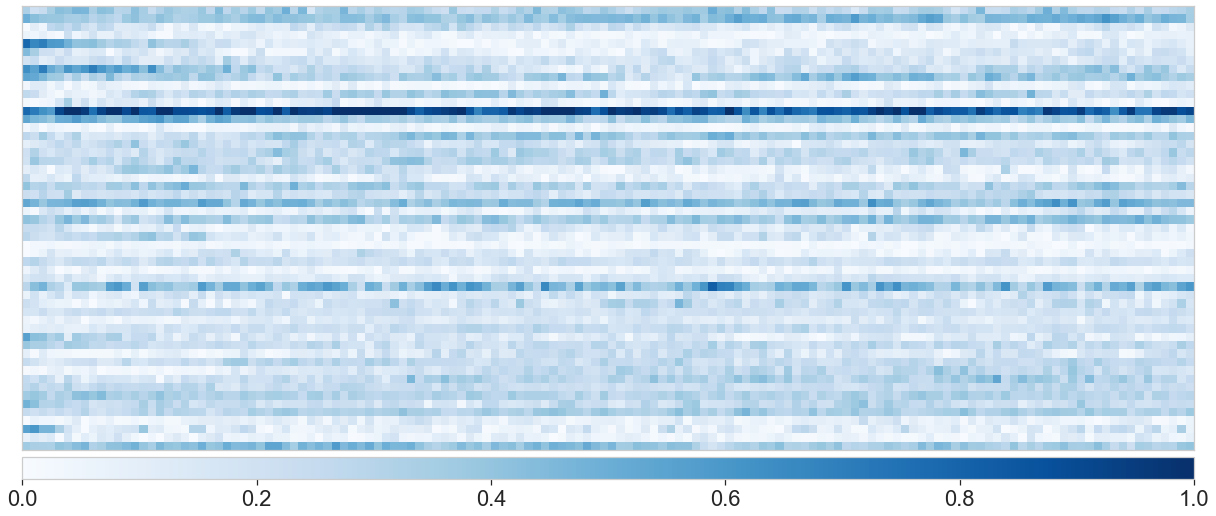

Approximation delta:  tensor([0.0680, 0.0155, 0.1231, 0.0257, 0.7007, 0.5104, 0.0946, 0.1956, 0.1366,
        0.4216, 0.2816, 0.7479, 0.2303, 0.5488, 0.4207, 0.1373, 0.2834, 0.2137,
        0.2275, 0.2113, 0.2158, 0.0309, 0.2342, 0.3020, 0.1412, 0.0596, 0.0606,
        0.1233, 0.4019, 0.5149, 0.2070, 0.0879, 0.0852, 0.0046, 0.0471, 0.9341,
        0.2180, 0.1752, 0.6389, 0.4519, 0.0758, 0.3467, 0.1885, 0.2759, 0.1020,
        0.1212, 0.1559, 0.1838, 0.3411, 0.0380, 0.0455, 0.2434, 0.3259, 0.0150,
        0.2675, 0.0338, 0.0678, 0.4359, 0.1488, 0.0725, 0.0542, 0.1730, 0.0956,
        0.5288, 0.1438, 0.0472, 0.3814, 0.1419, 0.1970, 0.0809, 0.1935, 0.1712,
        0.0973, 0.3932, 0.1167, 0.2618, 0.0980, 0.0224, 0.0820, 0.5405, 0.0115,
        0.3827, 0.0468, 0.2418, 0.0130, 0.1333, 0.5401, 0.2128, 0.1955, 0.4986,
        0.0692, 0.1541, 0.1748, 0.3752, 0.2806, 0.2653, 0.0680, 0.1726, 0.1752,
        0.2552, 0.1572, 0.0865, 0.4361, 0.0116, 0.0913, 0.3584, 0.4375, 0.2520,
        0.1824, 0.

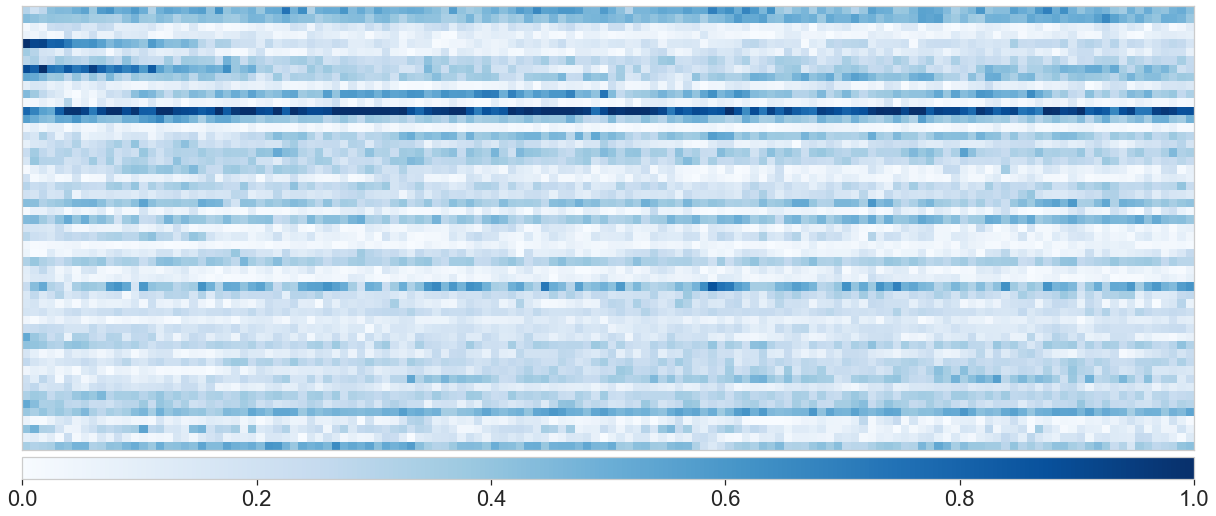

In [11]:
ig = IntegratedGradients(model)


model.zero_grad()
attr_ig0, delta = ig.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig1, delta = ig.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

In [1]:

ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)


model.zero_grad()
attr_ig_nt0, delta = nt.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig_nt1, delta = nt.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()



NameError: name 'IntegratedGradients' is not defined